#  Tutorial 10: Vertical Integration

<p align="left">
  <img src="../../_static/uncorrected_umap_7.png" width="150">
</p>
> This tutorial walks you through the vertical integration of two spatial transcriptomics (ST) datasets from mouse breast cancer.


 ## Import necessary packages

In [1]:
from sklearn import metrics
import torch
import copy
import os
import random
import numpy as np
from semanticst.loading_batches import PrepareDataloader
from semanticst.loading_batches import Dataloader
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch.utils.data as data
from semanticst.main import Config

/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


## Read data

In [2]:
dataset="Breast Cancer"

file_path = '/home/roxana/Projects/Data/7.Mouse_Breast_Cancer_Sample_1/'
adata = sc.read_h5ad(file_path + 'filtered_feature_bc_matrix.h5ad')

adata.var_names_make_unique()

/tmp/ipykernel_135079/3362214606.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inplace=True)
/tmp/ipykernel_135079/3362214606.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inpla

(4894.35, 14786.65, -15408.3, -3499.7)

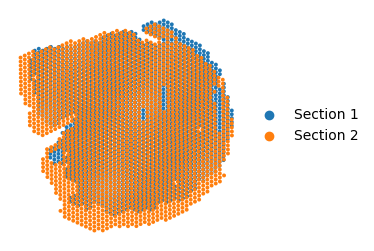

In [3]:
plt.rcParams["figure.figsize"] = (3, 3)
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inplace=True)
ax = sc.pl.embedding(adata, basis='spatial',
                color='data',
                show=False)
ax.set_title('')
ax.axis('off')
#plt.savefig('aligned_image_plot_7.png', dpi=600, bbox_inches='tight')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You are using *{device}*")

You are using *cpu*


## Train the model

In [8]:
dtype = "Visium"  # Change to "h5ad" if necessary
config=Config(device=device,dtype=dtype, use_mini_batch=False)
from semanticst.SemanticST_main import Semantic as Trainer
config_used = copy.copy(config)
model = Trainer(adata,config)  
adata=model.train()  # Train the model


🚀 Welcome to SemanticST! 🚀

📢 Recommendation: If your dataset contains more than 40000 spots or cells, we suggest using **mini-batch training** for efficiency.

✅ Using Full Dataset Training (No Mini-Batching). 🔥


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Begin to train ST data...


Learning Semantic graphs: 100%|████████████| 250/250 [00:14<00:00, 17.79epoch/s]


Semantic Graph Learning Completed


Feature Learning Epochs: 100%|██████████████| 1000/1000 [02:19<00:00,  7.15it/s]


## Clustering on SemanticST's embedding

In [23]:
# clustering

n_cluster=10
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from semanticst.utils import clustering
clustering(adata,seed=41, n_clusters=n_cluster, method=tool,key='emb_decoder')

fitting ...
  |======================================================================| 100%


## Run Seurat+Harmony

In [12]:
import harmonypy as hm

meta_data = adata.obs[['data']]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
data_mat = adata.obsm['X_pca']
vars_use = ['data']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i+1) for i in range(res.shape[1])], index=adata.obs.index)
adata.obsm[f'seurat.Harmony'] = res_df

2025-02-18 15:40:03,200 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-18 15:40:04,196 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-18 15:40:04,206 - harmonypy - INFO - Iteration 1 of 10
2025-02-18 15:40:04,633 - harmonypy - INFO - Iteration 2 of 10
2025-02-18 15:40:05,041 - harmonypy - INFO - Iteration 3 of 10
2025-02-18 15:40:05,454 - harmonypy - INFO - Iteration 4 of 10
2025-02-18 15:40:05,865 - harmonypy - INFO - Iteration 5 of 10
2025-02-18 15:40:06,279 - harmonypy - INFO - Iteration 6 of 10
2025-02-18 15:40:06,510 - harmonypy - INFO - Iteration 7 of 10
2025-02-18 15:40:06,708 - harmonypy - INFO - Iteration 8 of 10
2025-02-18 15:40:06,906 - harmonypy - INFO - Iteration 9 of 10
2025-02-18 15:40:07,103 - harmonypy - INFO - Iteration 10 of 10
2025-02-18 15:40:07,302 - harmonypy - INFO - Stopped before convergence


## Comparing the batch effect removal across methods

/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Catego

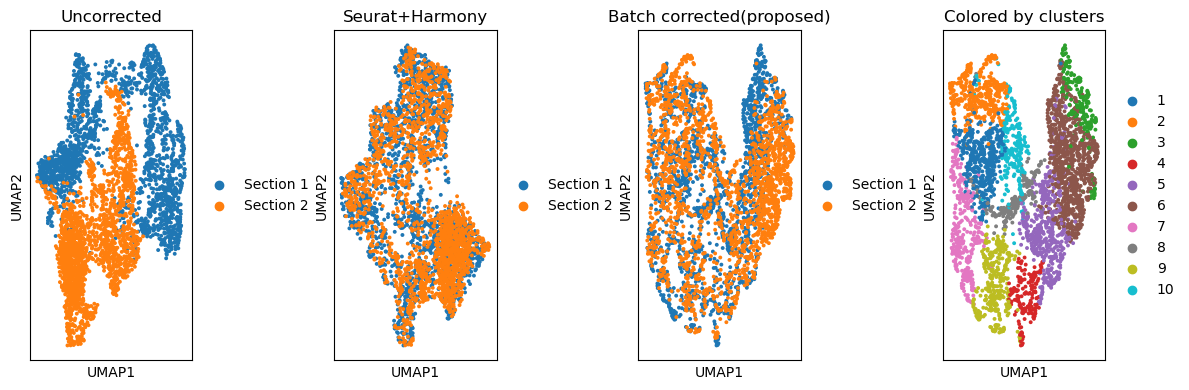

In [21]:
fig, ax_list = plt.subplots(1, 4, figsize=(12, 4))

### Plotting UMAP before batch effect correction


sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color='data', title='Uncorrected',
                  ax = ax_list[0],
                  show=False)
#############
sc.pp.neighbors(adata, use_rep='seurat.Harmony', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='data', title='Seurat+Harmony',
                  ax = ax_list[1],
                  show=False)
### Plotting UMAP after batch effect correction
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,
           color='data',
           ax=ax_list[2],
           title='Batch corrected(proposed)',
           #legend_loc = 'bottom margin',
           show=False)

### Color by predicted domains
sc.pl.umap(adata, color='domain', ax=ax_list[3], title='Colored by clusters', show=False)

plt.tight_layout(w_pad=0.02)

## Visualising SemanticST's Results

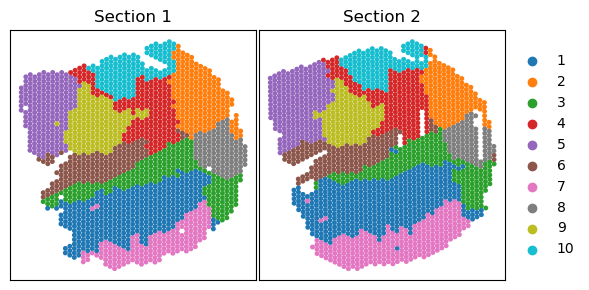

In [24]:
from sklearn import metrics
### Splitting adata into Section 1 and Section 2
adata_section1 = adata[adata.obs['data']=='Section 1', :]
adata_section2 = adata[adata.obs['data']=='Section 2', :]

fig, ax_list = plt.subplots(1, 2, figsize=(6, 3))
sc.pl.embedding(adata_section1,
                basis='spatial',
                color='domain',
                show = False,
                s=50,
                title='Section 1',legend_loc='none',
                ax = ax_list[0])
ax_list[0].set_xlabel('')
ax_list[0].set_ylabel('')
sc.pl.embedding(adata_section2,
                basis='spatial',
                color='domain',
                show = False,
               s=50,
                title = ['Section 2'],
                ax = ax_list[1])
ax_list[1].set_xlabel('')
ax_list[1].set_ylabel('')
plt.tight_layout(w_pad=0.2)
plt.savefig('semanticST_clusters_7.png', dpi=600, bbox_inches='tight')

### Compute the ILISI Score of SemanticST's output 

In [19]:
import harmonypy as hm
ILISI = hm.compute_lisi(adata.obsm['emb_pca'], adata.obs[['data']], label_colnames=['data'])[:, 0]

In [20]:
mean_ilisi = ILISI.mean()
print("Mean iLISI score:", mean_ilisi)

Mean iLISI score: 1.5697542846017478


## Clustering on Seurat.Harmony output

In [ ]:
# clustering

n_cluster=10
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from utils import clustering
clustering(adata,seed=41, n_clusters=n_cluster, method=tool,key='seurat.Harmony')

## Visualsing Seurat+Harmony's Results

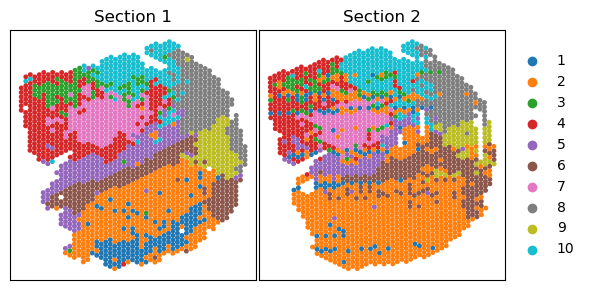

In [17]:
from sklearn import metrics
### Splitting adata into Section 1 and Section 2
adata_section1 = adata[adata.obs['data']=='Section 1', :]
adata_section2 = adata[adata.obs['data']=='Section 2', :]

fig, ax_list = plt.subplots(1, 2, figsize=(6, 3))
sc.pl.embedding(adata_section1,
                basis='spatial',
                color='domain',
                show = False,
                s=50,
                title='Section 1',legend_loc='none',
                ax = ax_list[0])
ax_list[0].set_xlabel('')
ax_list[0].set_ylabel('')
sc.pl.embedding(adata_section2,
                basis='spatial',
                color='domain',
                show = False,
               s=50,
                title = 'Section 2',
                ax = ax_list[1])
ax_list[1].set_xlabel('')
ax_list[1].set_ylabel('')
plt.tight_layout(w_pad=0.2)
#plt.savefig('seurat.Harmony_clusters_7.png', dpi=600, bbox_inches='tight')

### Compute the ILISI Score of seurat+Harmony's output 

In [21]:
ILISI_h = hm.compute_lisi(adata.obsm['X_pca'], adata.obs[['data']], label_colnames=['data'])[:, 0]


### Comparison of ILISI  Scores 

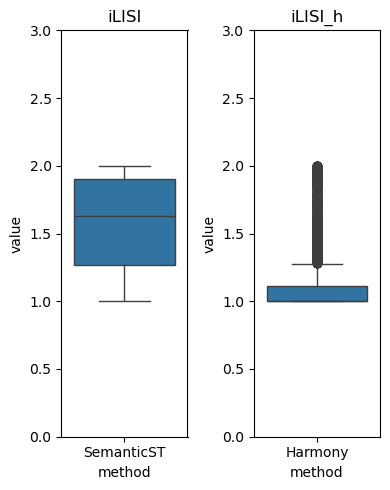

In [22]:
import seaborn as sns

df_ILISI = pd.DataFrame({
    'method': 'SemanticST',
    'value': ILISI,
    'type': ['ILISI']*len(ILISI)
})


df_ILISI_h = pd.DataFrame({
    'method': 'Harmony',
    'value': ILISI_h ,
    'type': ['ILISI_h ']*len(ILISI_h )
})

fig, axes = plt.subplots(1,2,figsize=(4, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_ILISI_h , x='method', y='value', ax=axes[1])
axes[0].set_ylim(0, 3)
axes[1].set_ylim(0, 3)
axes[0].set_title('iLISI')
axes[1].set_title('iLISI_h')

plt.tight_layout()

